Authors: Yair Andrew Gross & Rafi Kepecs

## Setup

In [1]:
# Enter API account credentials
api_key = 'ob-p-U-gaUnUtxckXt--pKUfcvYeSbZs3CkZ580x6E0grzGkuCdYF0qD9OhItiDQ58j48i7o'

%pip install onboard.client

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from onboard.client import RtemClient
from onboard.client.models import PointSelector

client = RtemClient(api_key=api_key)
# client.whoami()

Note: you may need to restart the kernel to use updated packages.


## Database Exploration

### Contents Overview

The RTEM database contains three main levels. The top level is made up
of **buildings**. Each building can contain multiple pieces of
**equipment**. Each piece of equipment can contain multiple **points**.

A point represents a single sensor, attached to one specific piece of
equipment, within a particular building. Each point, or sensor, records
data over time. The database, via the RTEM API, provides access to that
time series data for each point.

In order to take a closer look at the basic contents of the RTEM API,
we will create dataframes containing all the buildings, equipment, and
points using the API's built in "get_all_[]" methods.

These are quite large, they can be expected to take some time to load.

In [2]:
all_buildings = pd.DataFrame(client.get_all_buildings())
all_equipment = pd.DataFrame(client.get_all_equipment())
all_points = pd.DataFrame(client.get_all_points())

### Basic Statistics

As shown below, there are 229 buildings in the database, with over 6,000
pieces of equipment between them, and a total of nearly 45,000
individual sensors (points).

The statistical distributions of points per piece of equipment and
pieces of equipment per building are also shown below. There is a very
range in both categories, from just one to several hundred. The other
information in the stats table is more revealing, but to understand the
breakdown better we will have to split these up by type in the next
section.

In [3]:
print(f"Buildings: {len(all_buildings.index)}")
print(f"Equipment: {len(all_equipment.index)}")
print(f"Points: {len(all_points.index)}")

Buildings: 229
Equipment: 6085
Points: 44390


In [4]:
# Get stats for pieces of equipment per building
equip_per_bldg_avg = all_equipment.groupby(by='building_id').size().describe()

# Get stats for points per piece of equipment
points_per_equip_avg = all_points.groupby(by='equip_id').size().describe()

# Combine into single dataframe
stats = pd.DataFrame([equip_per_bldg_avg, points_per_equip_avg])
stats = stats.loc[:, stats.columns!='count']
stats.index = ['Equipment Per Building', 'Points Per Equipment']

# Show results
stats

,mean,std,min,25%,50%,75%,max
Equipment Per Building,26.572052,50.564882,1.0,4.0,8.0,25.0,393.0
Points Per Equipment,7.294988,16.952032,1.0,1.0,3.0,10.0,950.0


### Stats By Equipment Type

It make sense that different types of equipment would typically require
different numbers of sensors, so lets break down the equipment by type. 
The following table is a simple count of how many of each type
of equipment there are in the database, as well as statistical
information on the numbers of points per piece of equipment, by type.

In [5]:
# Find the number of points associated with each piece of equipment
points_per_equip = all_points.groupby(by='equip_id',dropna=False)\
    .size().reset_index().rename(columns={0:'count'}).sort_values('equip_id')

# Add number of points as a column to the all_equipment dataframe
all_equipment = all_equipment.sort_values(by='id')
all_equipment['point_count'] = points_per_equip['count']

# Get stats for points per equipment type
equip_type_stats = all_equipment.\
    groupby(['equip_type_name'],dropna=False)\
    ['point_count'].describe().reset_index()

equip_type_stats.head(8)

,equip_type_name,count,mean,std,min,25%,50%,75%,max
0,Air Handling Unit,1165.0,6.332189,13.142179,1.0,1.0,2.0,6.00,292.0
1,Battery,61.0,4.983607,0.288202,4.0,5.0,5.0,5.00,6.0
2,Boiler,140.0,6.957143,11.047882,1.0,1.0,2.5,10.00,75.0
3,Chilled Water Plant,50.0,6.860000,8.727180,1.0,2.0,2.5,10.25,46.0
4,Chiller,151.0,4.973510,6.353946,1.0,1.0,2.0,5.50,34.0
5,Condenser,18.0,9.944444,9.058452,1.0,3.5,11.0,11.00,40.0
6,Cooling Tower,65.0,7.076923,8.045394,1.0,2.0,3.0,10.00,27.0
7,Dry Cooler,1.0,1.000000,NaN,1.0,1.0,1.0,1.00,1.0


Breaking these numbers down slight farther, the next table shows the
number of each equipment _subtype_ in the database, as well as a
statistical summary of the numbers of points per piece of equipment by 
type/subtype.

In [6]:
# Get stats for points per equipment subtype
equip_subtype_stats = all_equipment.\
    groupby(['equip_type_name','equip_subtype_name'],dropna=False)\
    ['point_count'].describe().reset_index()

equip_subtype_stats

,equip_type_name,equip_subtype_name,count,mean,std,min,25%,50%,75%,max
0,Air Handling Unit,Energy Recovery Ventilation Unit,4.0,3.250000,2.061553,1.0,1.75,3.5,5.00,5.0
1,Air Handling Unit,Make Up Air Unit,5.0,2.800000,2.489980,1.0,1.00,1.0,5.00,6.0
2,Air Handling Unit,Roof Top Unit,275.0,5.276364,9.140628,1.0,1.00,2.0,5.00,95.0
3,Air Handling Unit,NaN,881.0,6.695800,14.205812,1.0,1.00,3.0,8.00,292.0
4,Battery,NaN,61.0,4.983607,0.288202,4.0,5.00,5.0,5.00,6.0
5,Boiler,Hot Water Boiler,6.0,2.833333,2.136976,1.0,2.00,2.0,2.75,7.0
6,Boiler,Steam Boiler,4.0,2.500000,1.290994,1.0,1.75,2.5,3.25,4.0
7,Boiler,NaN,130.0,7.284615,11.392391,1.0,1.00,3.0,10.00,75.0
8,Chilled Water Plant,NaN,50.0,6.860000,8.727180,1.0,2.00,2.5,10.25,46.0
9,Chiller,Absorption Chiller,14.0,4.214286,5.950806,1.0,1.00,2.0,3.00,18.0


To visualize the widely varying numbers of points per piece of
equipment, by equipment type. Note that in order to be able to see the
numbers at all, a log scale had to be used for the y-axis.

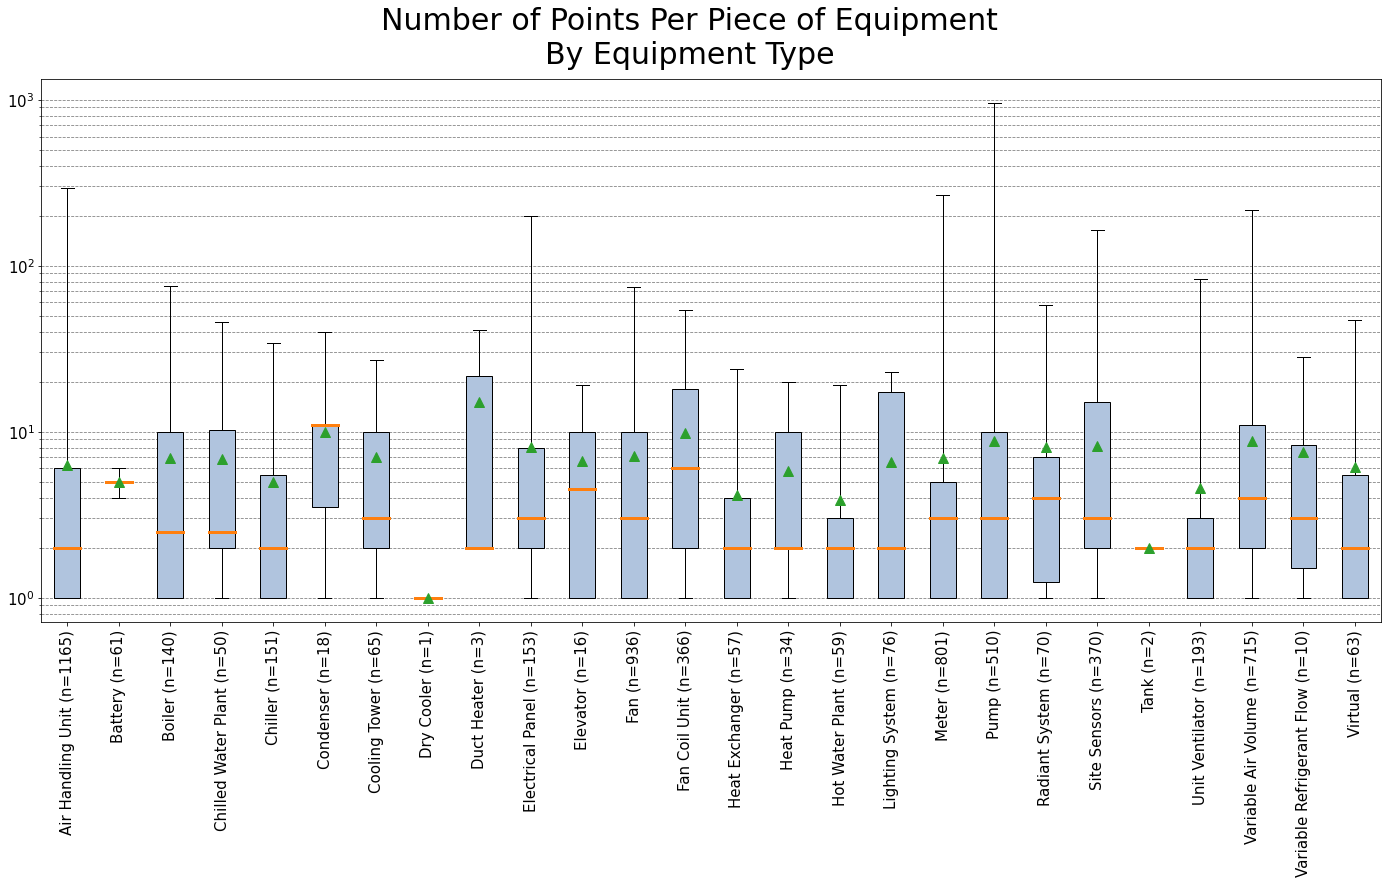

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Change matplotlib default patch color (boxplot fill color)
mpl.rcParams['patch.facecolor'] = 'lightsteelblue'
# Change boxplot default formatting
mpl.rcParams['boxplot.medianprops.linewidth'] = 3.0
mpl.rcParams['boxplot.meanprops.markersize'] = 10

# Format boxplot stats
stats = [
    {
        'mean': float(equip_type_stats.loc[[i],'mean']),
        'med': float(equip_type_stats.loc[[i],'50%']),
        'q1': float(equip_type_stats.loc[[i],'25%']),
        'q3': float(equip_type_stats.loc[[i],'75%']),
        'whislo': float(equip_type_stats.loc[[i],'min']),
        'whishi': float(equip_type_stats.loc[[i],'max'])
    } for i in range(len(equip_type_stats.index))
]

# Create boxplots
fig, ax = plt.subplots(figsize=(24,10))
ax.bxp(stats, showmeans=True,showfliers=False,patch_artist=True);

# Create xtick labels
labels = ["{} (n={})".format(
    equip_type_stats['equip_type_name'][i],
    int(equip_type_stats['count'][i])
) for i in range(len(equip_type_stats.index))]

# Format figure
fig.suptitle("Number of Points Per Piece of Equipment\nBy Equipment Type", fontsize=30)
ax.set_xticklabels(labels, rotation=90, fontsize=15);
ax.set_yscale('log')
ax.grid(axis='y', which='both', color='gray', linestyle='--')
ax.tick_params(axis='y', labelsize=15)

# Save figure
plt.savefig('equip_type_points_boxplot.png', dpi=300, bbox_inches='tight')

## Data Selection

### Choosing a Building

We decide to focus our analysis on a single building. To choose a
building we sorted all the buildings by square footage and selected one
that was large, while having a reasonable amount of equipment and
number of points (not too many or too few).The largest building on the
list (id: 439) has just a single piece of equipment with just one point
associated with it. The second largest building (id: 418) has nearly 400
pieces of equipment and nearly 600 points, too many to effectively
analyze. The next three buildings (ids: 140, 65, 48) all lie in between,
with 12 to 38 pieces of equipment, and 42 to 209 points each. We'll take 
a closer look at the equipment and points associated with each building
before deciding which one to analyze more closely.

In [8]:
# Sorting buildings by square footage
all_buildings.sort_values(by='sq_ft', ascending=False)[['id', 'sq_ft', 'equip_count', 'point_count']].head(10)

,id,sq_ft,equip_count,point_count
17,439,3000000.0,1,1
37,418,2800000.0,393,586
140,185,2486000.0,26,209
65,142,2400000.0,12,42
48,98,2338000.0,38,132
164,256,1993000.0,3,30
25,417,1898155.0,45,599
136,194,1700000.0,6,16
33,438,1500000.0,221,1111
113,141,1325000.0,41,82


The table and histograms in the following sections shows the number of pieces of equipment of each type in each of the buildings we have selected to analyze more closely. Each building contains a unique combination of equipment types
in a range of quantities.

In [9]:
# Choose buildings to look at more closely
building_ids = [185, 142, 98]

# Count pieces of equipment by type and building
equip_groups = all_equipment.loc[all_equipment['building_id'].isin(building_ids)]\
    .groupby(by=['building_id','equip_type_name']).size()#.reset_index().rename(columns={0:'equip_count'})

equip_groups

building_id  equip_type_name    
98           Chilled Water Plant     1
             Chiller                 6
             Cooling Tower          10
             Meter                   2
             Pump                   17
             Site Sensors            1
             Virtual                 1
142          Air Handling Unit       4
             Chiller                 3
             Heat Exchanger          1
             Meter                   1
             Pump                    1
             Site Sensors            1
             Virtual                 1
185          Air Handling Unit       3
             Cooling Tower           6
             Fan                     9
             Fan Coil Unit           2
             Pump                    6
dtype: int64

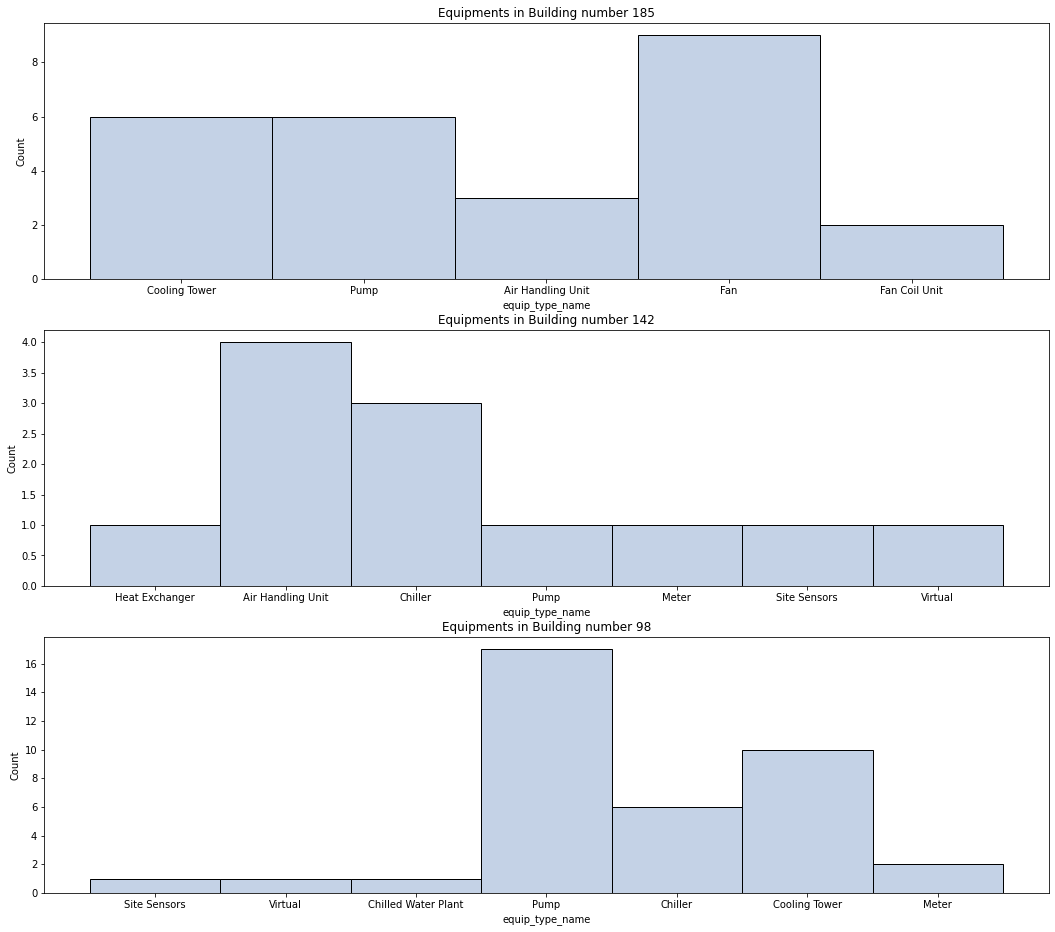

In [10]:
fig, axes = plt.subplots(len(building_ids), 1, figsize=(18, 16))


for i in range(len(building_ids)):
    id = building_ids[i]
    building_equipment = pd.DataFrame(client.get_building_equipment(id))

    sns.histplot(ax = axes[i], data=building_equipment, x="equip_type_name", binwidth=3)
    axes[i].set_title(f"Equipments in Building number {id}");

### Choosing Equipment Type 

After looking more closely into the numbers of pieces and the number of points within each of several of the above
equipment types, we decided to focus on the cooling towers in the first building (id=185). As shown in the table in the section below, there are six cooling towers in that building, each with 5 points (except one cooling tower with 8 points).

In [11]:
# Specify ID of building to search for
building_id = 185

# Choose equipment types to include in search (by abbreviation)
equip_abbrs = ['CT']

# Get all equipment to include in search
building_equipment = pd.DataFrame(client.get_building_equipment(building_id))
query_equip = building_equipment[building_equipment['equip_type_abbr'].isin(equip_abbrs)]

# Select all points for chosen equipment 
query = PointSelector()
query.equipment = list(query_equip['id'])
result = client.select_points(query)
result_points = pd.DataFrame(client.get_points_by_ids(result['points']))

# Show number of points per piece of equipment in search
result_points.groupby('equip_id').size().reset_index().rename(columns={0:'count'})

,equip_id,count
0,34958,5
1,34960,5
2,34962,5
3,34970,5
4,34971,5
5,34977,8


The following expansion of the above data shows that all six cooling towers contain not only the same
number of points, but actually the same point types. That means they should be able to directly compared
to one another. Note that the "Damper Position" is, in the context of a cooling tower, equivalent to the
"Condenser Water Valve Position".

In [12]:
result_points.groupby(by=['equip_id', 'type']).size()

equip_id  type                            
34958     Command                             1
          Damper Position                     2
          Return Air Temperature              1
          Status                              1
34960     Command                             1
          Damper Position                     2
          Return Air Temperature              1
          Status                              1
34962     Command                             1
          Damper Position                     2
          Return Air Temperature              1
          Status                              1
34970     Command                             1
          Condenser Water Valve Position      2
          Return Air Temperature              1
          Status                              1
34971     Command                             1
          Condenser Water Valve Position      2
          Return Air Temperature              1
          Status                             

## Timeseries Analysis

### Setup

Change first and last update times from unix time to standard datetime

In [13]:
from datetime import datetime, timezone

datetime.fromtimestamp(0, timezone.utc)

result_points.first_updated = result_points.first_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min()
result_points.last_updated = result_points.last_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).max()

In [14]:
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries
import pytz

# Select your timezone
tz = pytz.timezone('UTC')

### Temperature Data

Recalling that only one of the six cooling towers in building 185 has sensors monitoring the
outside air temperature and humidity, that external temperature data will be considered in the
analysis of the other equipment as well. Before doing this, in order to validate the accurcacy
of that data, we compared it with New York City historical weather data from wunderground.com.

The first of the following two sections shows the cooling tower's sensor data for June 2nd, 2019. The next section shows the historical temperature data for the same period as reported by wunderground.com. The CT data seems to be slightly choppier, perhaps due to a higher sample rate or other factors, but the broader trends remain the same. We therefore conclude that the CT data is an accurate reporting of outdoor temperature conditions and can be used in tandem with other equipment/sensor data.

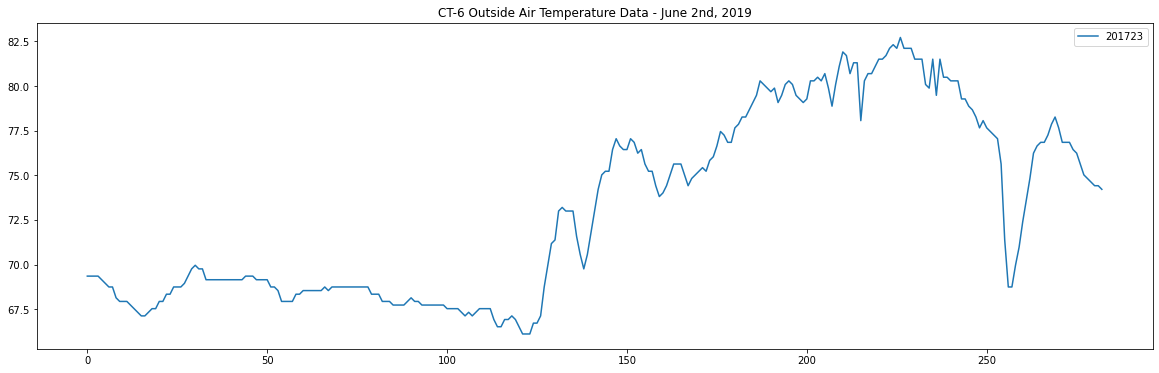

In [15]:
# Select your date and time
start = datetime(2019,6,2,0,0,0).replace(tzinfo=tz)
end = datetime(2019,6,3,0,0,0).replace(tzinfo=tz)

time_data = TimeseriesQuery(point_ids = [201723], start = start, end = end)

# Excute query (will return an object)
query_results = client.stream_point_timeseries(time_data)
# Convert to dataframe
sensor_data = points_df_from_streaming_timeseries(query_results)

# Plot
plt.figure(figsize=(20,6))
sns.lineplot(data=sensor_data)
plt.title("CT-6 Outside Air Temperature Data - June 2nd, 2019");

In [26]:
# import image module
from IPython.display import Image

url = 'https://github.com/yairg98/Data-Driven-Problem-Solving/raw/main/Assignments/Final%20Project/historical-weather-screenshot.png'

# get the image
Image(url=url, width=1150)

### Data Resampling

As shown in the following section, cooling tower status is binary (on/off). The towers are turned on and off with a frequency of anywhere from minutes to weeks. Therefore, a moving average of the in order to correlate the outside air temperature with the cooling tower, the sampling rates needed to be adjusted and averaged over a longer period of time. This allows us to capture seasonal temperature trends, which provide a more insightful view of the data trends.

Before expanding the window to look at data on a longer time scale, the following example demonstrates the effects of resampling on the June 2nd from above. Notice how the overall shape of the curve remains the same, but the smaller fluctuations are smoothed out.

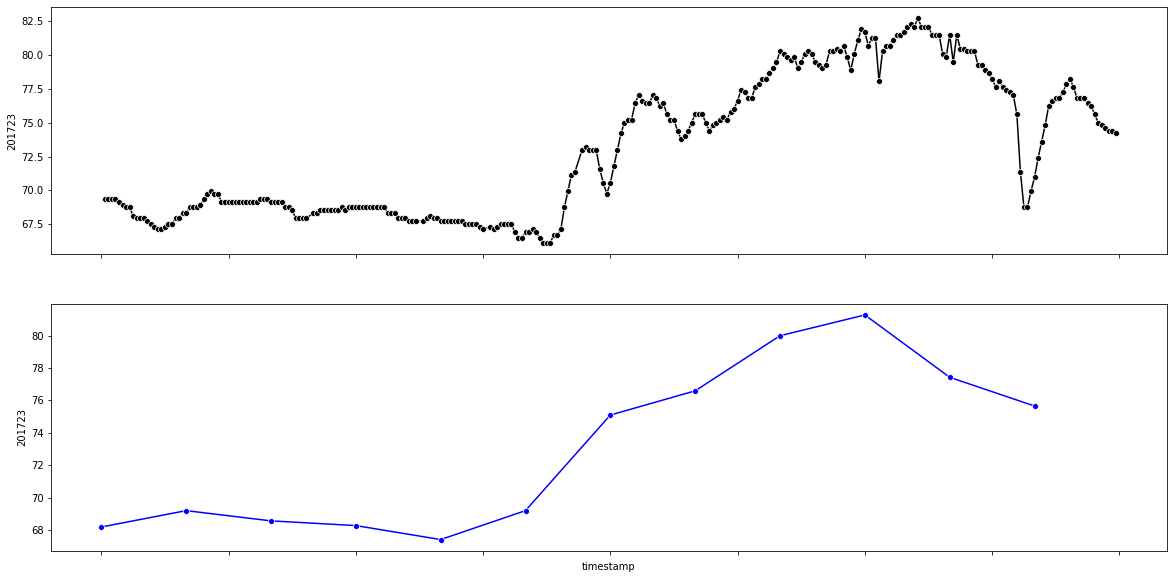

In [17]:
sensor_number = 201723

sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
sensor_data_resampled = sensor_data.resample('2H', on="timestamp").mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)

sns.lineplot(data=sensor_data, x='timestamp', y=sensor_number , marker="o", color="k", ax = axes[0])
sns.lineplot(data=sensor_data_resampled, x='timestamp', y=sensor_number, marker="o", color='b', ax=axes[1])

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([]);

The next set of graphs shows the raw on/off data for each of the six cooling towers over a period of a few months. Notice that they sometimes turn ona nd off relatively rapidly, while sometimes staying fixed (either on or off) for weeks at a time. The irregulrity of these cooling tower usage patterns suggests the possibility of improved efficiency in their management.

In [18]:
# Select your date and time
start = datetime(2018,6,1,0,0,0).replace(tzinfo=tz)
end = datetime(2020,6,1,0,0,0).replace(tzinfo=tz)

timeseries_query = TimeseriesQuery(point_ids = result['points'], start = start, end = end)

# Excute query (will return an object)
query_results = client.stream_point_timeseries(timeseries_query)
# Convert to dataframe
sensor_data = points_df_from_streaming_timeseries(query_results)

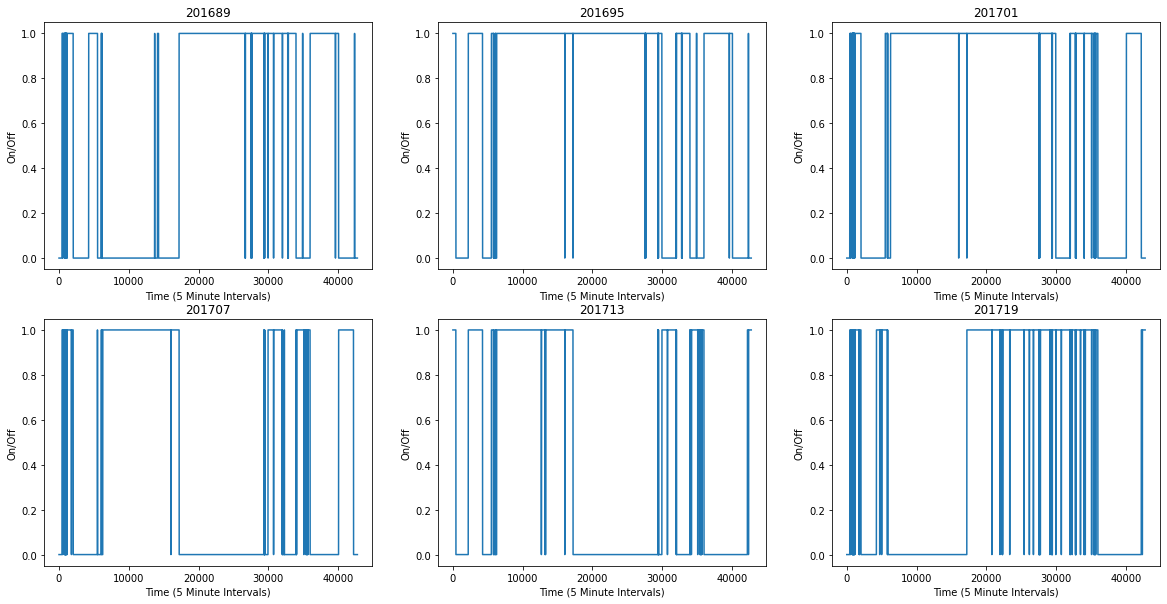

In [19]:
# ID's of selected cooling tower status points
ct_status_ids = [201689, 201695, 201701, 201707, 201713, 201719]

# Plot status of each cooling tower over time
fig, axes = plt.subplots(2,3,  figsize = (20,10))
sns.lineplot(ax = axes[0,0], data = sensor_data[ct_status_ids[0]]).set(title = ct_status_ids[0], ylabel = 'On/Off', xlabel = 'Time (5 Minute Intervals)')
sns.lineplot(ax = axes[0,1], data = sensor_data[ct_status_ids[1]]).set(title = ct_status_ids[1], ylabel = 'On/Off', xlabel = 'Time (5 Minute Intervals)')
sns.lineplot(ax = axes[0,2], data = sensor_data[ct_status_ids[2]]).set(title = ct_status_ids[2], ylabel = 'On/Off', xlabel = 'Time (5 Minute Intervals)')
sns.lineplot(ax = axes[1,0], data = sensor_data[ct_status_ids[3]]).set(title = ct_status_ids[3], ylabel = 'On/Off', xlabel = 'Time (5 Minute Intervals)')
sns.lineplot(ax = axes[1,1], data = sensor_data[ct_status_ids[4]]).set(title = ct_status_ids[4], ylabel = 'On/Off', xlabel = 'Time (5 Minute Intervals)')
sns.lineplot(ax = axes[1,2], data = sensor_data[ct_status_ids[5]]).set(title = ct_status_ids[5], ylabel = 'On/Off', xlabel = 'Time (5 Minute Intervals)')

plt.show()

### Outside Air Temperature VS Cooling Tower Usage

The following sections resample the cooling tower on/off data and the outside air temperature data with a frequency on the order of multiple days over a span of several months. This comparison clearly shows an inneficient management of the cooling towers as the seasons change and the outside air temperature decreases from the 80s to a comfortable level in the high 60s and low 70s.

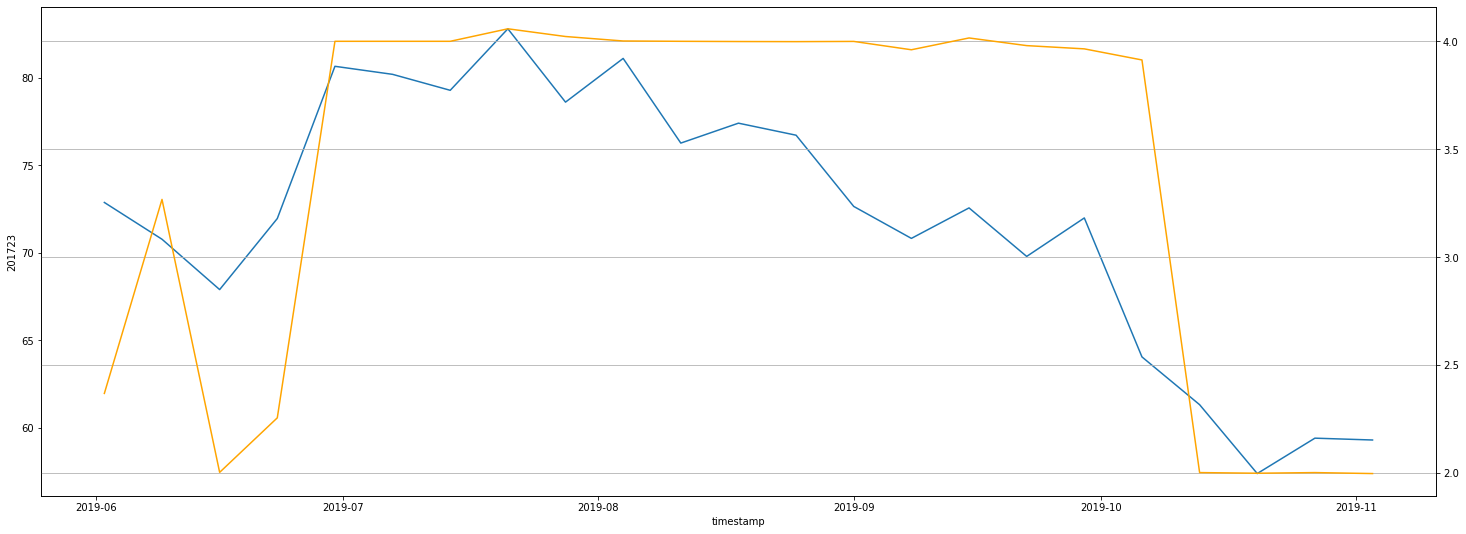

In [30]:
# ID of outside air temperature sensor point
point_id = 201723

# Retrieve air temperature and cooling tower status data
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
sensor_data_resampled = sensor_data.resample('1W', on="timestamp").mean()
status_sensors = sensor_data_resampled[ct_status_ids]
summed_status_sensors = status_sensors.sum(axis=1)

# Plot
plt.figure(figsize=(25,9))
ax = sns.lineplot(data = sensor_data_resampled[point_id])
ax2 = ax.twinx()
sns.lineplot(data = summed_status_sensors, ax=ax2, color='orange')
plt.grid()